# Imports

In [1]:
import librosa

import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import einops
import typing as tp
import warnings
from dataclasses import dataclass, field

import math
import numpy as np
import matplotlib.pyplot as plt

# Audio Data (Torch)

In [2]:
samples_torch, sr_torch = torchaudio.load("C:/Users/julio/Desktop/dev/ai/projects/nae/data/Balance Memory.wav")

metadata = torchaudio.info("C:/Users/julio/Desktop/dev/ai/projects/nae/data/Balance Memory.wav")

print(metadata)

AudioMetaData(sample_rate=32000, num_frames=480000, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [3]:
samples_torch, samples_torch.shape

(tensor([[-0.0263, -0.0267, -0.0266,  ..., -0.2393, -0.2393, -0.2401]]),
 torch.Size([1, 480000]))

In [ ]:
# TESTING CELL: preprocess the audio, acording to the user input mono or stereo
*shape, channel, length = samples_torch.shape

samples_torch_exp = samples_torch.expand(*shape, 2, length)

samples_torch_exp, samples_torch_exp.shape

(tensor([[-0.0263, -0.0267, -0.0266,  ..., -0.2393, -0.2393, -0.2401],
         [-0.0263, -0.0267, -0.0266,  ..., -0.2393, -0.2393, -0.2401]]),
 torch.Size([2, 480000]))

In [65]:
# TESTING CELL: preprocess the audio, acording to the user input audio sample rate 24khz
samples_torch_sr_24 = torchaudio.transforms.Resample(sr_torch, 24000)(samples_torch)

samples_torch_sr_24, samples_torch_sr_24.shape

(tensor([[-0.0230, -0.0277, -0.0263,  ..., -0.2397, -0.2361, -0.2480]]),
 torch.Size([1, 360000]))

In [62]:
# TESTING CELL: preprocess the audio, acording to the user input audio sample rate 48khz
samples_torch_sr_48 = torchaudio.transforms.Resample(sr_torch, 48000)(samples_torch)

samples_torch_sr_48, samples_torch_sr_48.shape

(tensor([[-0.0261, -0.0291, -0.0253,  ..., -0.2404, -0.2701, -0.1659]]),
 torch.Size([1, 720000]))

In [77]:
# TESTING CELL: scale up the audio with calculated volume scale
mono = samples_torch_sr_24.unsqueeze(0).mean(dim=1, keepdim=True)
vol = mono.pow(2).mean(dim=2, keepdim=True).sqrt()
samples_torch_scale_24 = samples_torch_sr_24 / vol

mono, vol, samples_torch_scale_24.view(-1, 1)

(tensor([[[-0.0230, -0.0277, -0.0263,  ..., -0.2397, -0.2361, -0.2480]]]),
 tensor([[[0.1537]]]),
 tensor([[-0.1493],
         [-0.1805],
         [-0.1709],
         ...,
         [-1.5594],
         [-1.5355],
         [-1.6128]]))

In [4]:
# converting into numpy to match matplotlib input
samples_torchnp = samples_torch.numpy()

samples_torchnp, samples_torchnp.shape

(array([[-0.02627563, -0.02667236, -0.02664185, ..., -0.23928833,
         -0.23931885, -0.2401123 ]], dtype=float32),
 (1, 480000))

In [5]:
# explicting waveform aspects
num_channels_torch = samples_torchnp.shape[0]
audio_samples_torch = samples_torchnp.shape[1]

num_channels_torch, audio_samples_torch

(1, 480000)

In [6]:
# calculating audio duration for spectogram plotting
time_axis = torch.arange(0, audio_samples_torch) / sr_torch

time_axis, time_axis.shape

(tensor([0.0000e+00, 3.1250e-05, 6.2500e-05,  ..., 1.5000e+01, 1.5000e+01,
         1.5000e+01]),
 torch.Size([480000]))

Text(0.5, 0.98, 'Waveform With Torch')

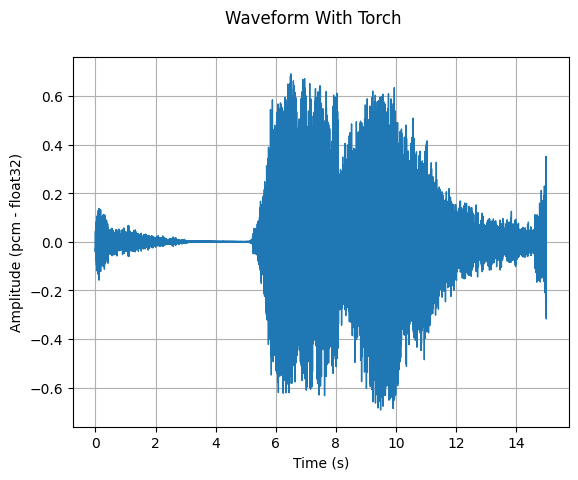

In [7]:
# plot in waveform with pytorch
fig, axes = plt.subplots(num_channels_torch, 1)
if num_channels_torch == 1:
    axes = [axes]
for c in range(num_channels_torch):
    axes[c].plot(time_axis, samples_torchnp[c], linewidth=1)
    axes[c].grid(True)
    axes[c].set_xlabel("Time (s)")
    axes[c].set_ylabel("Amplitude (pcm - float32)")
fig.suptitle("Waveform With Torch")

Text(0.5, 0.98, 'Spectogram With Torch')

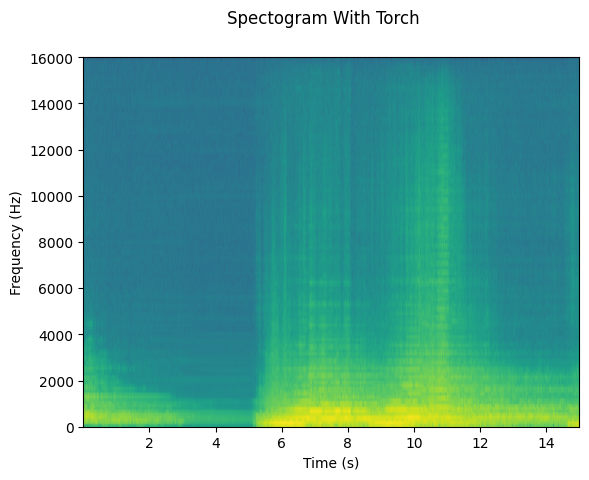

In [8]:
# plot spectogram with pytorch
fig, axes = plt.subplots(num_channels_torch, 1)
if num_channels_torch == 1:
    axes = [axes]
for c in range(num_channels_torch):
    axes[c].specgram(samples_torchnp[c], Fs=sr_torch)
    axes[c].set_xlabel("Time (s)")
    axes[c].set_ylabel("Frequency (Hz)")

plt.suptitle("Spectogram With Torch")

# Audio Data (Librosa)

In [9]:
# import audio into samples
audio_samples, sample_rate = librosa.load("C:/Users/julio/Desktop/dev/ai/projects/nae/data/Balance Memory.wav")

print(
    f'''AUDIO SAMPLES
    ------------------------------------------
    samples: {audio_samples},
    shape: {audio_samples.shape},
    sample rate: {sample_rate},
    duration: {audio_samples.shape[0]/sample_rate}
    '''
)

AUDIO SAMPLES
    ------------------------------------------
    samples: [-0.02099079 -0.02828838 -0.02593338 ... -0.23950645 -0.23623453
 -0.24782246],
    shape: (330750,),
    sample rate: 22050,
    duration: 15.0
    


In [10]:
# convert samples into spectogram time-series domain without phase information (time-frame, features)
audio_stft = librosa.stft(audio_samples)
audio_decibels = librosa.amplitude_to_db(audio_stft, ref=np.max)

print(
    f'''AUDIO DECIBELS
    ------------------------------------------
    data: {audio_decibels},
    time-frame: {audio_decibels.shape[0]},
    feature: {audio_decibels.shape[1]}
    '''
)

AUDIO DECIBELS
    ------------------------------------------
    data: [[-54.275192 -59.89358  -80.       ... -61.664333 -50.987064 -43.09458 ]
 [-54.117733 -59.470417 -80.       ... -39.976444 -46.921448 -34.238876]
 [-53.94733  -58.313316 -76.227295 ... -26.429234 -24.678818 -22.918774]
 ...
 [-80.       -80.       -80.       ... -80.       -80.       -72.84019 ]
 [-80.       -80.       -80.       ... -80.       -80.       -72.84181 ]
 [-80.       -80.       -80.       ... -80.       -80.       -72.84227 ]],
    time-frame: 1025,
    feature: 646
    


C:\Users\julio\AppData\Local\Temp\ipykernel_10124\3809001913.py:3: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  audio_decibels = librosa.amplitude_to_db(audio_stft, ref=np.max)


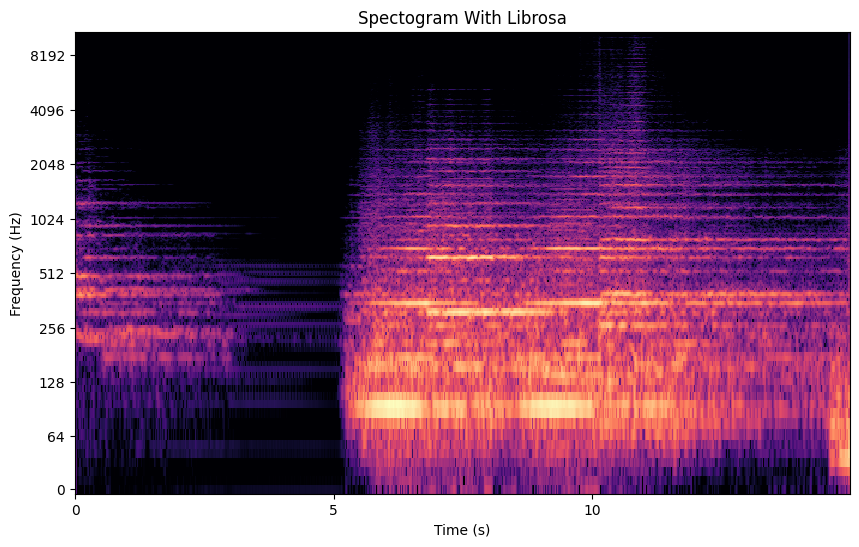

In [11]:
# plot in spectogram with librosa
plt.figure(figsize=(10, 6))
librosa.display.specshow(audio_decibels, sr=sample_rate, x_axis="time", y_axis="log", cmap="magma")
plt.title("Spectogram With Librosa")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

In [53]:
# algorithms input format
audio_input = torch.tensor(audio_decibels).unsqueeze(0)

audio_input, audio_input.shape

(tensor([[[-54.2752, -59.8936, -80.0000,  ..., -61.6643, -50.9871, -43.0946],
          [-54.1177, -59.4704, -80.0000,  ..., -39.9764, -46.9214, -34.2389],
          [-53.9473, -58.3133, -76.2273,  ..., -26.4292, -24.6788, -22.9188],
          ...,
          [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -72.8402],
          [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -72.8418],
          [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -72.8423]]]),
 torch.Size([1, 1025, 646]))

# Core Vector Quantization

## K-Means

### Function

#### sample_vector

In [13]:
# define codebook size and each entry/page size
def sample_vector(samples, n_clusters: int):
    time_frames, device = samples.shape[0], samples.device
    if time_frames >= n_clusters:
        indices = torch.randperm(time_frames, device=device)[:n_clusters]
    else:
        indices = torch.randint(0, time_frames, (n_clusters,), device=device)
    return samples[indices]

In [14]:
v_means = sample_vector(audio_input, n_clusters=1024)

v_means, v_means.shape

(tensor([[-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -70.3455],
         [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -68.7234],
         [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -69.9173],
         ...,
         [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -68.5799],
         [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -69.7659],
         [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -66.8195]]),
 torch.Size([1024, 646]))

### Network

In [15]:
# return a codebook with entries of random audio time features
def kmeans(samples, n_clusters, n_iters):
    features_dim, samples_dtype = samples.shape[-1], samples.dtype
    means = sample_vector(samples, n_clusters)
    for i in range(n_iters):
        diffs = einops.rearrange(samples, "n d -> n () d") - einops.rearrange(means, "c d -> () c d")
        print(i, diffs.shape)
        dists = -(diffs**2).sum(dim=-1)
        buckets = dists.max(dim=-1).indices

        bins = torch.bincount(buckets, minlength=n_clusters)
        zero_mask = bins == 0
        bins_mask_clamped = bins.masked_fill(zero_mask, 1)

        new_means = buckets.new_zeros(n_clusters, features_dim, dtype=samples_dtype)
        new_means.scatter_add_(0, einops.repeat(buckets, "n -> n d", d=features_dim), samples)
        new_means = new_means / bins_mask_clamped[..., None]

        means = torch.where(zero_mask[..., None], means, new_means)
    return means, bins, buckets

#### Data

In [16]:
v_samples_rearrange = einops.rearrange(audio_input, "n d -> n () d")

v_samples_rearrange.shape

torch.Size([1025, 1, 646])

In [17]:
v_means_rearrange = einops.rearrange(v_means, "c d -> () c d")

v_means_rearrange.shape

torch.Size([1, 1024, 646])

In [18]:
v_diffs = v_samples_rearrange - v_means_rearrange

v_diffs.shape

torch.Size([1025, 1024, 646])

In [19]:
# v_dists = -(v_diffs ** 2).sum(dim=-1)

# v_dists.shape

In [20]:
# v_buckets = v_dists.max(dim=-1).indices

# v_buckets, v_buckets.shape

#### Testing

In [21]:
# means, bins, buckets = kmeans(audio_input, n_clusters=1024, n_iters=10)

# means.shape, bins, buckets

## EuclideanCodebook

### Functions

In [22]:
def uniform_init(*shape: int):
    t = torch.empty(*shape)
    nn.init.kaiming_uniform(t)
    return t

In [23]:
# virtual codebook embed initialization
v_uniform_init = uniform_init(1024, 646)

v_uniform_init, v_uniform_init.shape

C:\Users\julio\AppData\Local\Temp\ipykernel_10124\3428648820.py:3: FutureWarning: `nn.init.kaiming_uniform` is now deprecated in favor of `nn.init.kaiming_uniform_`.
  nn.init.kaiming_uniform(t)


(tensor([[-0.0363,  0.0862, -0.0286,  ..., -0.0011, -0.0051,  0.0319],
         [-0.0437, -0.0505,  0.0672,  ...,  0.0659, -0.0104, -0.0709],
         [ 0.0585, -0.0552,  0.0365,  ..., -0.0505,  0.0891,  0.0228],
         ...,
         [ 0.0463, -0.0857, -0.0291,  ...,  0.0501,  0.0359,  0.0260],
         [-0.0759, -0.0427,  0.0388,  ...,  0.0613, -0.0032, -0.0249],
         [ 0.0095, -0.0080,  0.0500,  ..., -0.0690,  0.0842,  0.0664]]),
 torch.Size([1024, 646]))

In [24]:
# converting codebook embed initialization to network parameters
v_uniform_init = nn.Parameter(v_uniform_init)

isinstance(v_uniform_init, nn.Parameter)

True

In [25]:
def world_size():
    if torch.distributed.is_initialized():
        return torch.distributed.get_world_size()
    else:
        return 1

In [26]:
world_size()

1

In [27]:
def is_distributed():
    return world_size > 1

In [28]:
def _is_complex_or_float(x):
    return torch.is_complex(x) or torch.is_floating_point(x)

In [29]:
def broadcast_tensors(tensors: tp.Iterable[torch.Tensor], src: int = 0):
    if not is_distributed():
        return
    tensors = [tensor for tensor in tensors if _is_complex_or_float(tensor)]
    handles = []
    for tensor in tensors:
        handle = torch.distributed.broadcast(tensor, src, async_op=True)
        handles.append(handle)
    for handle in handles:
        handle.wait()

In [30]:
def ema_inplace(mov_avg, new, decay):
    mov_avg.data.mul_(decay).add_(new, alpha=(1-decay))

In [31]:
def laplace_smoothing(x, n_categories, epsilon):
    return (x + epsilon) / (x.sum() + n_categories * epsilon)

### Network

In [32]:
class EuclideanCodebook(nn.Module):
    def __init__(
            self, 
            dim: int,
            codebook_size: int, 
            kmeans_init: False,
            kmeans_iters: int = 10,
            decay: float = 0.99,
            epsilon: float = 1e-5,
            thresold_ema_code: int = 2
            ):
        super().__init__()

        init_fn: tp.Union[tp.Callable[..., torch.Tensor], tp.Any] = uniform_init if not kmeans_init else torch.zeros
        embed = init_fn(codebook_size, dim)

        self.decay = decay
        self.codebook_size = codebook_size
        self.kmeans_iters = kmeans_iters
        self.epsilon = epsilon
        self.thresold_ema_code = thresold_ema_code

        self.register_buffer("inited", torch.Tensor([not kmeans_init]))
        self.register_buffer("cluster_size", torch.zeros(codebook_size))
        self.register_buffer("embed", embed)
        self.register_buffer("embed_avg", embed.clone())

    @torch.jit.ignore
    def init_embed_(self, x):
        if self.inited: return
        embed, cluster_size = kmeans(x, self.codebook_size, self.n_iters)
        self.inited.data.copy_(torch.Tensor[True])
        self.cluster_size.data.copy_(cluster_size)
        self.embed.data._copy(embed)
        self.embed_avg.data._copy(embed.clone())
        broadcast_tensors(self.buffers())

    def replace_(self, samples, mask):
        m_codebook = torch.where(
            mask[..., None], sample_vector(samples, self.codebook_size), self.embed
        )
        self.embed.data._copy(m_codebook)

    def expired_code(self, batch_samples):
        if self.thresold_ema_code == 0: 
            return
        
        expired_code = self.cluster_size < self.thresold_ema_code
        if not torch.any(expired_code): 
            return
        
        batch_samples = einops.rearrange(batch_samples, "... d -> (...) d")
        self.replace_(batch_samples, mask=expired_code)
        broadcast_tensors(self.buffers())

    def preprocess(self, x):
        return einops.rearrange(x, "... d -> (...) d")
    
    def quantize(self, x):
        embed = self.embed.t()
        dist = -(
            x.pow(2).sum(1, keepdim=True) 
            + 2 * x @ embed 
            - embed.pow(2).sum(0, keepdim=True)
        )
        emb_ind = dist.max(dim=-1).indices
        return emb_ind
    
    def postprocess_emb(self, emb_ind, shape):
        return emb_ind.view(*shape[:-1])
    
    def dequantize(self, emb_ind):
        return F.embedding(emb_ind, self.embed)
    
    def encode(self, x):
        shape = x.shape
        x = self.preprocess(x)
        x = self.quantize(x)
        x = self.postprocess_emb(x, shape)
        return x
    
    def decode(self, x):
        return self.dequantize(x)
    
    def forward(self, x):
        shape, dtype = x.shape, x.dtype
        x = self.preprocess(x)
        self.init_embed_(x)

        emb_ind = self.quantize(x)
        emb_onehot = F.one_hot(emb_ind, self.codebook_size).type(dtype)

        emb_ind = self.postprocess_emb(emb_ind, shape)
        quantize = self.dequantize(emb_ind)

        if self.training:
            ema_inplace(self.cluster_size, emb_onehot.sum(0), self.decay)
            emb_x = x.t() @ emb_onehot
            ema_inplace(self.embed_avg, emb_x.t(), self.decay)
            cluster_size = (
                laplace_smoothing(self.cluster_size, self.codebook_size, self.epsilon)
                * self.cluster_size.sum()
            )
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(1)
            self.embed.data.copy_(embed_normalized)

        return quantize, emb_ind

#### Testing

In [33]:
# converting audio samples into euclidean model acceptable format
v_audio_input = sample_vector(audio_input, 1024)

v_audio_input, v_audio_input.shape

(tensor([[-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -70.0863],
         [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -70.3094],
         [-71.1377, -74.9051, -80.0000,  ..., -80.0000, -80.0000, -63.0836],
         ...,
         [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -69.9066],
         [-56.3009, -60.8766, -60.6905,  ..., -51.4637, -46.8957, -51.4006],
         [-54.1177, -59.4704, -80.0000,  ..., -39.9764, -46.9214, -34.2389]]),
 torch.Size([1024, 646]))

In [34]:
# virtual euclidean codebook model
euclidean_model = EuclideanCodebook(dim=646, codebook_size=1024, kmeans_init=False)

euclidean_model.embed, euclidean_model.embed.shape

C:\Users\julio\AppData\Local\Temp\ipykernel_10124\3428648820.py:3: FutureWarning: `nn.init.kaiming_uniform` is now deprecated in favor of `nn.init.kaiming_uniform_`.
  nn.init.kaiming_uniform(t)


(tensor([[-0.0021,  0.0012,  0.0891,  ..., -0.0718,  0.0014, -0.0119],
         [-0.0911, -0.0436, -0.0791,  ..., -0.0142,  0.0493,  0.0909],
         [ 0.0818, -0.0086,  0.0355,  ..., -0.0197,  0.0487, -0.0481],
         ...,
         [-0.0651, -0.0344, -0.0907,  ...,  0.0708,  0.0692, -0.0498],
         [-0.0379,  0.0719, -0.0376,  ..., -0.0234,  0.0487, -0.0172],
         [ 0.0379, -0.0430,  0.0591,  ...,  0.0021, -0.0121, -0.0389]]),
 torch.Size([1024, 646]))

In [35]:
# check for the model parameters numbers
total_p = sum(p.numel() for p in euclidean_model.parameters())

total_p

0

In [36]:
# encoding the samples into codebook index
v_emb_ind = euclidean_model.encode(v_audio_input)

v_emb_ind, v_emb_ind.shape

(tensor([759, 759, 759,  ..., 759, 762, 759]), torch.Size([1024]))

In [37]:
# checking how many random bins of euclidean codebook, can the audio data belongs to
bins = torch.bincount(v_emb_ind, minlength=1024)

bins, bins.shape

(tensor([0, 0, 0,  ..., 0, 0, 0]), torch.Size([1024]))

In [38]:
# counting how many bins where used in the codebook
v_zero_mask = bins == 0
num_false_bins = np.sum(np.array(v_zero_mask) == False)

num_false_bins

7

In [39]:
# now lets train the codebook to approximate the data (v_audio_data).
# edit: i tried to train the model, but it seems that the model doesnt has weight parameters to be improve.

# epochs = 50
# optim = optim.Adam(euclidean_model.parameters(), lr=1e-3)
# criterion = nn.MSELoss()

# for ep in range(epochs):
#     optim.zero_grad()
#     quantize, _ = euclidean_model(v_audio_input)
#     loss = criterion(quantize, audio_input)
#     loss.backward()
#     optim.step()
#     if ep % 10 == 0:
#         print(f"epoch {ep}, loss: {loss.item():.4f}")

## VectorQuantization

In [40]:
def default(codebook_dim: tp.Any, d_dim: tp.Any):
    return codebook_dim if codebook_dim is not None else d_dim

In [41]:
class VectorQuantization(nn.Module):
    def __init__(
            self, 
            dim: int,
            codebook_size: int,
            codebook_dim: int = None,
            kmeans_init: bool = True,
            kmeans_iters: int = 50,
            epsilon: float = 1e-5,
            decay: float = 0.99,
            thresold_ema_code: int = 2,
            commitment_weight: float = 1.,
            ):
        super().__init__()
        self.epsilon = epsilon
        self.commitment_weight = commitment_weight

        self.codebook_size = codebook_size
        self._codebook = EuclideanCodebook(dim, codebook_size, kmeans_init, kmeans_iters, decay, epsilon, thresold_ema_code)

        self.codebook_dim = default(codebook_dim, dim)
        requires_projection = self.codebook_dim != dim
        self.project_in = (nn.Linear(dim, codebook_dim) if requires_projection else nn.Identity())
        self.project_out = (nn.Linear(codebook_dim, dim) if requires_projection else nn.Identity())

    @property
    def codebook(self):
        return self._codebook.embed
    
    def encode(self, x):
        x = einops.rearrange(x, "b d n -> b n d")
        x = self.project_in(x)
        emb_ind = self._codebook.encode(x)
        return emb_ind

    def decode(self, x):
        x = self._codebook.decode(x)
        x = self.project_out(x)
        quantize = einops.rearrange(x, "b n d -> b d n")
        return quantize
    
    def forward(self, x):
        device = x.device
        x = einops.rearrange(x, "b d n -> b n d")
        x = self.project_in(x)

        quantize, emb_ind = self._codebook(x)

        if self.training:
            quantize = x + (quantize - x).detach()
        
        loss = torch.tensor([0.0], device=device, requires_grad=self.training)

        if self.training:
            if self.commitment_weight > 0:
                warnings.warn('detach gradient bug here!')
                commit_loss = F.mse_loss(quantize.detach(), x)
                loss += self.commitment_weight * commit_loss
        
        quantize = self.project_out(quantize)
        quantize = einops.rearrange(quantize, "b n d -> b d n")
        return quantize, emb_ind, loss

## ResidualVectorQuantization

In [42]:
class ResidualVectorQuantization(nn.Module):
    def __init__(self, *, num_quantizers, **kwargs):
        super().__init__()
        self.layers = nn.ModuleList(
            [VectorQuantization(**kwargs) for _ in range(num_quantizers)]
        )

    def forward(self, x, n_q: tp.Optional[int] = None):
        quantized_out = 0.0
        residual = x
        n_q = n_q or len(self.layers)

        all_ind = []
        all_loss = []
        for layer in range(self.layers[:n_q]):
            quantize, emb_ind, loss = layer(x)
            residual -= quantize
            quantized_out += quantize

            all_ind.append(emb_ind)
            all_loss.append(loss)

        out_ind, out_loss = map(torch.stack, (all_ind, all_loss))
        return quantized_out, out_ind, out_loss
    
    def encode(self, x: torch.Tensor, n_q : tp.Optional[int] = None) -> torch.Tensor:
        residual = x
        n_q = n_q or len(self.layers)
        all_ind = []
        for layer in self.layers[:n_q]:
            ind = layer.encode(residual)
            quantize = layer.decode(ind)
            residual -= quantize
            all_ind.append(ind)
        out_ind = torch.stack(all_ind)
        return out_ind
    
    def decode(self, q_indices: torch.Tensor) -> torch.Tensor:
        quantized_out = 0.0
        for i, indice in enumerate(q_indices):
            layer = self.layers[i]
            quantize = layer.decode(indice)
            quantized_out += quantize
        return quantized_out

# Residual Vector Quantization

## ResidualVectorQuantizer

### Class Object

In [43]:
@dataclass
class QuantizedResult:
    quantized: torch.Tensor
    codes: torch.Tensor
    bandwidth: torch.Tensor
    penalty: tp.Optional[torch.Tensor] = None
    metrics: dict = field(default_factory=dict)

### Functions

#### get_bandwidth_per_quantizer

In [44]:
def get_bandwidth_per_quantizers(self, frame_rate: int):
    return math.log2(self.bins) * frame_rate

In [45]:
math.log2(1024)

10.0

#### get_quantizers_per_bandwidth

In [46]:
def get_quantizers_per_bandwidth(self, frame_rate: int, bandwidth: tp.Optional[float] = None) -> int:
    bw_p_q = self.get_bandwidth_per_quantizers(frame_rate)
    n_q = self.n_q
    if bandwidth and bandwidth > 0.:
        n_q = int(max(1, math.floor(bandwidth * 1000) / bw_p_q))
    return n_q

In [47]:
v_bw_p_q = math.log2(1024) * 75

v_bw_p_q

750.0

In [48]:
max(1, 50)

50

In [49]:
v_n_q = int(max(1, math.floor((6 * 1000) / v_bw_p_q)))

v_n_q

8

### Network

In [50]:
class ResidualVectorQuantizer(nn.Module):
    def __init__(
            self, 
            dim: int = 256,
            n_q: int = 8,
            bins: int = 1024,
            decay: float = 0.99,
            kmeans_init: bool = False,
            kmeans_iters: int = 50,
            thresold_ema_code: int = 2,
            ):
        super().__init__()
        self.dim = dim
        self.n_q = n_q
        self.bins = bins
        self.decay = decay
        self.kmeans_init = kmeans_init
        self.kmeans_iters = kmeans_iters
        self.thresold_ema_code = thresold_ema_code
        self.vq = ResidualVectorQuantization(
            dim=dim, num_quantizers=n_q, codebook_size=bins, decay=decay, kmeans_init=kmeans_init, 
            kmeans_iters=kmeans_iters, thresold_ema_code=thresold_ema_code
        )

    def forward(self, x: torch.Tensor, frame_rate: int, bandwidth: tp.Optional[float] = None) -> QuantizedResult:
        bw_p_q = get_bandwidth_per_quantizers(frame_rate)
        n_q = get_quantizers_per_bandwidth(frame_rate, bandwidth)
        bw = torch.Tensor(n_q * bw_p_q).to(x)

        quantize, codes, commit_loss = self.vq(x, n_q=n_q)
        return QuantizedResult(quantize, codes, bw, penalty=torch.mean(commit_loss))

    def get_bandwidth_per_quantizers(self, frame_rate: int):
        return math.log2(self.bins) * frame_rate

    def get_quantizers_per_bandwidth(self, frame_rate: int, bandwidth: tp.Optional[float] = None) -> int:
        bw_p_q = self.get_bandwidth_per_quantizers(frame_rate)
        n_q = self.n_q
        if bandwidth and bandwidth > 0.:
            n_q = int(max(1, math.floor(bandwidth * 1000) / bw_p_q))
        return n_q

    def encode(self, x, frame_rate, bandwidth) -> torch.Tensor:
        n_q = self.get_quantizers_per_bandwidth(frame_rate, bandwidth)
        codes = self.vq.encode(x, n_q=n_q)
        return codes
    
    def decode(self, codes) -> torch.Tensor:
        return self.vq.decode(codes)

#### Testing

In [51]:
quantizer = ResidualVectorQuantizer()

print(f"number of codebooks: {quantizer.n_q}, codebooks size: {quantizer.bins}, codebooks entries dimension: {quantizer.dim}")

number of codebooks: 8, codebooks size: 1024, codebooks entries dimension: 256


C:\Users\julio\AppData\Local\Temp\ipykernel_10124\3428648820.py:3: FutureWarning: `nn.init.kaiming_uniform` is now deprecated in favor of `nn.init.kaiming_uniform_`.
  nn.init.kaiming_uniform(t)


In [54]:
codes = quantizer.encode(audio_input, sr_torch, None)

codes

RuntimeError: mat1 and mat2 shapes cannot be multiplied (646x1025 and 256x1024)